# Статистический анализ данных игр (сборный проект - 1)

В данном проекте мы изучим данные о различных играх. Для начала мы загрузим и обработаем данные, посмотрим правильно ли называются колонки, посмотрим есть ли пропуски в данных, если ли дубликаты. Если есть пропуски, то выясним причину возникновения и решим, оставлять их или нет. Дубликаты удалим. Далее с обработанными данными мы проведем анализ: посмотрим, сколько игр выпускалось в разные годы, выясним, важны ли для нас данные за все периоды. Посмотрим как менялись продажи по платформам за различные периоды, определим актульный для нас период и платформы. Выясним, как складываются продажи у популярных платформ за последние годы, растут или падают. Изучим, как рейтинг пользователей и критиков влияет на продажи игр. Посмотрим, какие жанры являются самыми прибыльными. После этого составим портрет пользователя каждого региона: топ-5 платформ, топ-5 жанров, влияение рейтинга ESRB на продажи. Далее проверим некоторые гипотезы и подведем общий итог.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import sqrt

### Шаг 1. Загрузка данных

In [2]:
try:
    games = pd.read_csv('/datasets/games.csv')
except:
    games = pd.read_csv('C:/datasets/games.csv')

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
games.duplicated().sum()

0

In [7]:
games.duplicated(subset=['Name', 'Platform', 'Year_of_Release']).sum()

2

In [8]:
#проверим датасет на неявные дубликаты
games.duplicated(subset=['Name', 'Platform', 'Year_of_Release']).sum()

2

Датасет содержит 16715 строк, среди которых есть 2 дубликата, и 11 столбцов. В названиях колонок встречаются заглавные буквы. Эти колонки необходимо будет привести к змеиному регистру. В данных имеются пропуски: сильнее всего это наблюдается в колонках 'Critic_Score', '
User_Scor', '
Rati', порядка 40-50%. Не все колонки представлены оптимальными типами данных: колонки 'Year_of_Release' и 'Critic_Score' имеет смысл преобразовать к типу 'int', так как в них содержатся целые числа, а колонку 'User_Score' к типу данных float, так как там содержится оценка пользвателей, выраженная в вещественных числах.   

### Шаг 2. Предобработка данных

In [9]:
# удалим неявные дубликаты
games.drop_duplicates(subset=['Name', 'Platform', 'Year_of_Release'], inplace=True)

In [10]:
#приведем названия столбцов к нижнему регистру
games.columns = games.columns.str.lower()

In [11]:
#удалим строки, где не указаны названия игр и их год
games.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True)

In [12]:
games.shape

(16443, 11)

In [13]:
games['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983.])

In [14]:
#заменим тип значения в колонке 'year_of_release' на 'int' тк там содержатся целые числа - год выпуска игры
games['year_of_release'] = games['year_of_release'].astype('int')

In [15]:
games['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [16]:
#заменим тип значения в колонке 'critic_score' на 'Int64' тк там содержатся целые числа и NAN
games['critic_score'] = games['critic_score'].astype('Int64')

In [17]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [18]:
#посмотрим на количество строк со значением колонки 'user_score' = 'tbd'
games[games['user_score'] == 'tbd']['user_score'].count()

2376

'tbd' означает что рейтинг игры не определен. Таких строк достаточно много в масштабах нашего датасета (порядка 15%), поэтому удаление такого количество строк может исказить наш анализ. Если 'tbd' превратить в 0, то это так же может поменять наши данные, так как из-за этого исказиться значение среднего и прочее. Поэтому оставим строки содержащие 'tbd', но переведем такие значения в колонке 'user_score' в NAN (пропуски). А все колонку приведем к типу данных 'float' для удобства в дальнейшей работе с данными.

In [19]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan

In [20]:
#заменим тип значения в колонке 'user_score' на 'float' тк там содержатся вещесвтенные числа и NAN
games['user_score'] = games['user_score'].astype('float')

In [21]:
#взглянем на информацию об обновленной таблице
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   Int64  
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 1.5+ MB


Типы данных колонок стали более удобными для работы с ними. Так же убавилось количество пропусков, за исключением трех последних столбцов. Эти пропуски могли возникнуть в результате того, что игры могли выходить давно, и данные о рейтингах не сохранились, либо игры были непопулярными и не были оценены, либо сами компании, выпускающие игры, не присваилали никакой рейтинг (возрастной) для того, чтобы больше пользователей захотели купить ее игру.

In [22]:
#посчитаем суммарные продажи во всех регионах и занесем их в новую колонку 'total_sales'
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [23]:
(1 - games.shape[0] / 16715) * 100

1.6272808854322474

In [24]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38


Были удалены неявные дубликаты в количестве 2 шт. Названия колонок были преобразованы к змеиному регистру. Были удалены строки, где не указаны названия игр и их год, так как эти данные являются основополагающими, и без них не остается смысла в оставшейся строке. В результате таблица убавилась меньше чем на 2%, что не превышает допустимого размера в 10%. Были заменены типы данных у некоторых колонок для удобства в дальнейшей работе. Также мы добавили новую колонку 'total_sales', в которой записаны суммарные продажи по каждой игре. Эта информация пригодится нам для дальнейшего анализа.

### Шаг 3. Исследовательский анализ данных

Посмотрим, сколько игр выпускалось за каждый год.

Text(0.5, 1.0, 'Количество выпущенных игр по годам')

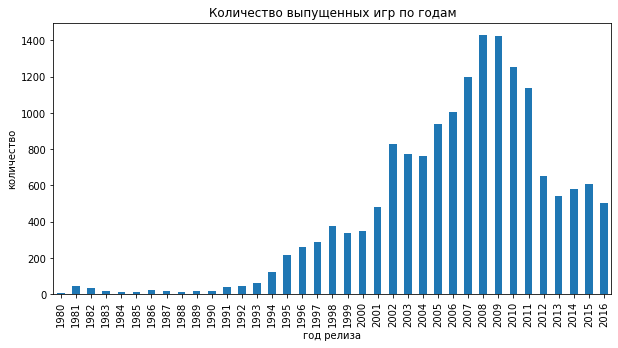

In [25]:
plt.figure(figsize=(10, 5))
games['year_of_release'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('год релиза')
plt.ylabel('количество')
plt.title('Количество выпущенных игр по годам')

Получилось, что до 1994 года выходило порядка 20-50 игр в год, а после этого пошло развитие этой индустрии с пиком в 2008-2009 годах (по 1400 игр в год). В дальнейшем стал происходить спад, и в 2016 году вышло порядка 500 игр. Это может быть связано с тем, что игры стали более сложными в разработке, и на выпуск игры стало требоваться больше времени. 

In [26]:
#кол-во игр  выпущенных до 1993 года
games[games['year_of_release'] < 1994]['name'].count()

365

Думаю, информация об играх, вышедших до 1994 года, не представляет для нас ценности. Во-первых, в каждый год их выходило очень мало. Во-вторых, многие платформы, на которых они выходили, уже не актуальны.

Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Посмотрим, как менялись продажи по платформам. Платформ достаточно много, поэтому будем рассматривать платформы с наибольшими суммарными продажами. Так же нас интересуют актуальные платформы, поэтому посмотроим на средний срок жизни платформ, и возьмем информации от нашего текущего (2016) года до (текущего года - срок жизни платформы).

In [27]:
# срок жизни платформы
#сделаем сводную таблицу, где индекс это платформа, а колонки это минимальный год релиза и максимальный год релиза на этой платформе
games_pt1 = games.pivot_table(index='platform', values=['year_of_release'], aggfunc=['min', 'max'])
#вычтем из максимального года минимальный и посчитаем среднее по всем платформам.
print('Среднее время жизни платформы:', round((games_pt1[('max', 'year_of_release')] - games_pt1[('min', 'year_of_release')]).mean(), 1))

Среднее время жизни платформы: 7.6


In [28]:
# код ревьюера
games.groupby('platform')['year_of_release'].nunique().mean()

7.67741935483871

Text(0, 0.5, 'суммарные продажи, млн')

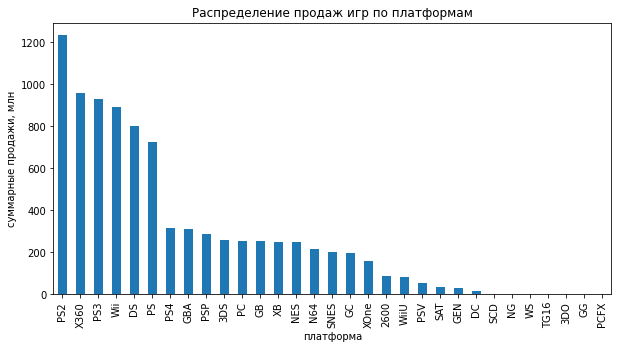

In [29]:
#посмотрим на распределение по продажам для различных платформ 
plt.figure(figsize=(10, 5))
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Распределение продаж игр по платформам')
plt.xlabel('платформа')
plt.ylabel('суммарные продажи, млн')

In [30]:
#возьмем самые популярные из них
platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS','PC', 'GB', 'XB', 'NES', 'N64', 'SNES', 'GC', 'XOne']

In [31]:
# код ревьюера
games.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False).head(6).index.to_list()

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

In [32]:
#создадим новый датафрейм, где будут самые популярные по продажам платформы и год выпуска будет = текущему - средний срок жизни
popular_platforms = games[(games['platform'].isin(platforms)) & (games['year_of_release'] > 2008)]

Text(0, 0.5, 'суммарные продажи, млн')

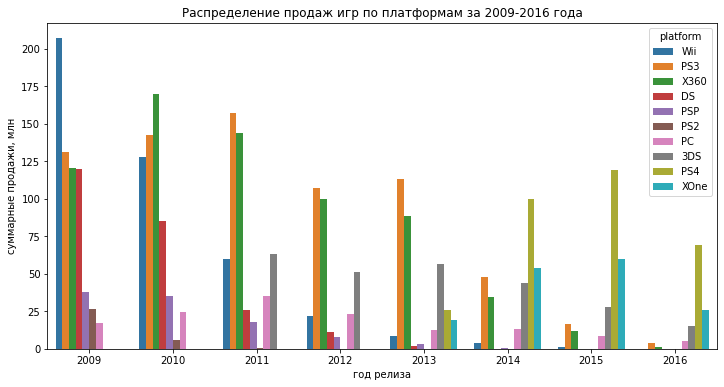

In [33]:
plt.figure(figsize=(12,6))
games_pt2 = popular_platforms.pivot_table(index=['year_of_release', 'platform'], values='total_sales', aggfunc='sum').sort_values(by=['year_of_release', 'total_sales'], ascending=[True, False])
sns.barplot(data=games_pt2.reset_index(), x='year_of_release', y='total_sales', hue='platform')
plt.title('Распределение продаж игр по платформам за 2009-2016 года')
plt.xlabel('год релиза')
plt.ylabel('суммарные продажи, млн')

На графике видно, что самые популярные плтаформы в 2009 году - Wii, PS3, X360, DS, к 2014 году практически исчезли. А с 2013 начали активно расти PS4, XOne, 3DS. Хотя наблюдается общая динамика снижения количества продаж игр на всех платформах. Для прогнозирования продаж на 2017 год имеет смысл рассматривать акутальный период - [2014, 2016] года, где рынок перераспределился между новыми игровыми платформами.

In [34]:
#новый датафрейм с играми вышедшими с 2014 года
games_df = games[(games['year_of_release'] >= 2014)].reset_index(drop=True)

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

Text(0, 0.5, 'продажи, млн')

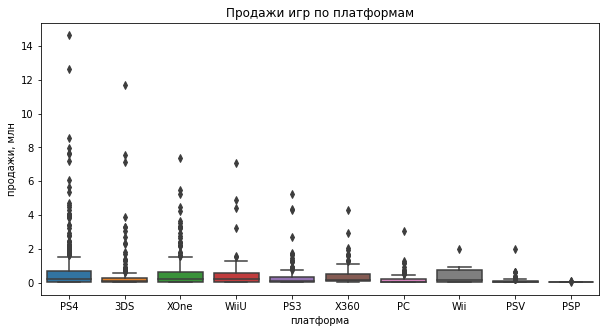

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='platform', y='total_sales', data=games_df)
plt.title('Продажи игр по платформам')
plt.xlabel('платформа')
plt.ylabel('продажи, млн')

Выбросы выше ящика говорят нам о количестве игр, с очень высокими относительно других игр, продажами. Такие игры можно назвать хитами.Видно, что наибольшее количество хитов выходит на акутальных платформах - PS4, 3DS, XOne. Рекордсменом является PS4. Чуть меньше на PS3, X360 - платформах предыдущего поколения. 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. В качестве платформы возьмем PS4, так как она является самой популярной за последние годы.
Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [36]:
games_ps4 = games_df[games_df['platform'] == 'PS4'].reset_index()

In [37]:
games_ps4.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,NaN,14.63
1,1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
2,3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
3,4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,<NA>,NaN,NaN,7.98
4,5,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66


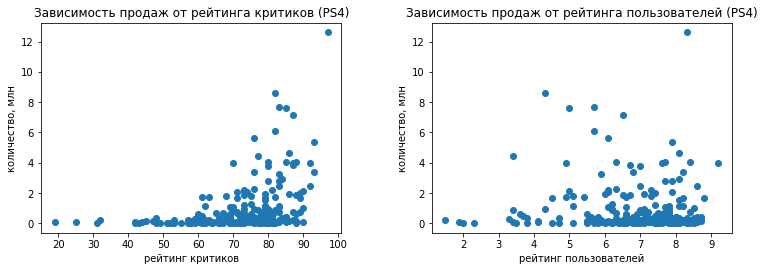

Корреляция между отзывами критиков и продажами = 0.40190287811475334
Корреляция между отзывами пользователями и продажами = -0.04318585997193634


In [38]:
#удалим строки, где нет оценок пользователей и критиков
new_games_ps4 = games_ps4.dropna(subset =['critic_score', 'user_score'])
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=1.0, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)

plt.subplot(1, 2, 1)
plt.xlabel('рейтинг критиков')
plt.ylabel('количество, млн')
plt.title('Зависимость продаж от рейтинга критиков (PS4)')
plt.plot(new_games_ps4['critic_score'].to_numpy(), new_games_ps4['total_sales'].to_numpy(), 'o')

plt.subplot(1, 2, 2)
plt.xlabel('рейтинг пользователей')
plt.ylabel('количество, млн')
plt.title('Зависимость продаж от рейтинга пользователей (PS4)')
plt.plot(new_games_ps4['user_score'].to_numpy(), new_games_ps4['total_sales'].to_numpy(), 'o')
plt.show()

print(f'Корреляция между отзывами критиков и продажами = {new_games_ps4["critic_score"].astype("float").corr(new_games_ps4["total_sales"])}')
print(f'Корреляция между отзывами пользователями и продажами = {new_games_ps4["user_score"].corr(new_games_ps4["total_sales"])}')

Присутсвует корреляция между рейтингом критиков и продажами игры на PS4. Это можно объяснить тем, что критики при оценке используют некоторые парамерты, которые является объективными, не опираясь только на свой субъективный опыт. Также своей оценкой критики могут формировать отношение к игре у потенциальных покупателей. Поэтому высокие оценки, побуждают покупателя приобрести игру, а низкие - нет.
Что касается зависимости отзывов пользователей от продаж - то тут корреляция около нуля, это значит что зависимости нет. И пользователи сильно не опираются на мнение друг друга при покупке игр.

Посмотрим на топ-4 популярные платформы. 

In [39]:
popular_platforms = games_df.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False).head(4).index.to_list()
popular_platforms

['PS4', 'XOne', '3DS', 'PS3']

Влияние продаж от рейтингов критиков и пользвателей на PS4 мы рассмотрели. Посмотрим, как складывается ситуация на других популярных платформах.

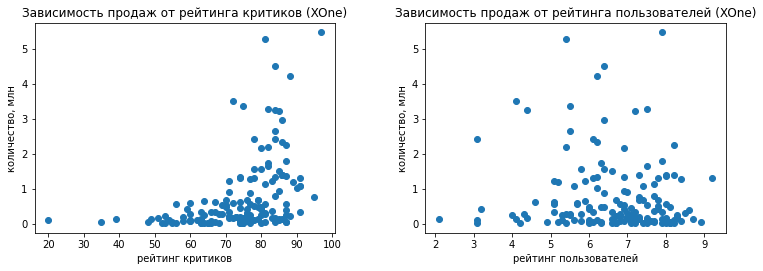

Корреляция между отзывами критиков и продажами на XOne = 0.42211185105557647
Корреляция между отзывами пользователями и продажами на XOne = -0.0917343450331075


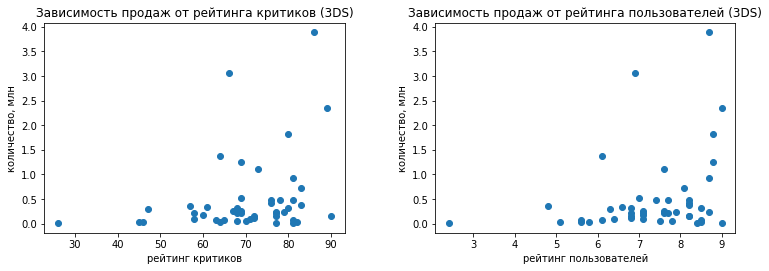

Корреляция между отзывами критиков и продажами на 3DS = 0.28468579095782925
Корреляция между отзывами пользователями и продажами на 3DS = 0.2798498792503281


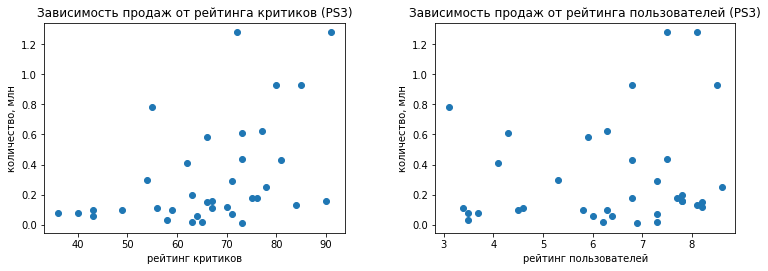

Корреляция между отзывами критиков и продажами на PS3 = 0.44657460493190704
Корреляция между отзывами пользователями и продажами на PS3 = 0.15659516181359956


In [40]:
popular_platforms_without_ps4 = popular_platforms[1:]
for i in popular_platforms_without_ps4:
    massiv = games_df[games_df['platform'] == i].dropna(subset =['critic_score', 'user_score']).reset_index()
    plt.figure(figsize=(12, 4))
    plt.title(f'Зависимость продаж на {i}')
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=1.0, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)

    plt.subplot(1, 2, 1)
    plt.xlabel('рейтинг критиков')
    plt.ylabel('количество, млн')
    plt.title(f'Зависимость продаж от рейтинга критиков ({i})')
    plt.plot(massiv['critic_score'].to_numpy(), massiv['total_sales'].to_numpy(), 'o')

    plt.subplot(1, 2, 2)
    plt.xlabel('рейтинг пользователей')
    plt.ylabel('количество, млн')
    plt.title(f'Зависимость продаж от рейтинга пользователей ({i})')
    plt.plot(massiv['user_score'].to_numpy(), massiv['total_sales'].to_numpy(), 'o')
    plt.show()

    print(f'Корреляция между отзывами критиков и продажами на {i} = {massiv["critic_score"].astype("float").corr(massiv["total_sales"])}')
    print(f'Корреляция между отзывами пользователями и продажами на {i} = {massiv["user_score"].corr(massiv["total_sales"])}')

Присутсвтует корреляция между оценками критиков и продажами игры. Так, корреляция присутствует на всех ислледуемых платформах, меняется только ее значение. На стационарных приставках (PS4, PS3, XOne) она состявляет порядка 0.4, а на портативной (3DS) чуть меньше, 0.28. Это можно объяснить тем, что критики при оценке используют некоторые парамерты, которые является объективными, не опираясь только на свой субъективный опыт. Также своей оценкой критики могут формировать отношение к игре у потенциальных покупателей. Поэтому высокие оценки, побуждают покупателя приобрести игру, а низкие - нет.
Корреляция же  между оценками пользвателей и продажами игры различается среди популярных приставок. У PS4 и XOne она около нуля, то есть зависимости нет. Возможно из-за того, что это новые приставки, не сформировано много отзывов об играх на них, и пользователи предпочитают опираться только на мнение критиков. В приставках PS3 и 3DS дело обстоит иначе, там присутсвует корреляция, на PS3 - 0.16, а на 3DS - 0.28. Можно сказать, что пользователи портавтиной приставки, сильнее опираются на мнение других игроков, чем пользователи стационарных приставок.

Такая ситуация не связана с конкретной платформой, скорее она связана с поведением пользователя, поэтому корреляция между рейтингами и продажами на других платформах будут аналогичными.

Посмотрим на общее распределение продаж игр по жанрам.

Text(0, 0.5, 'суммарные продажи, млн')

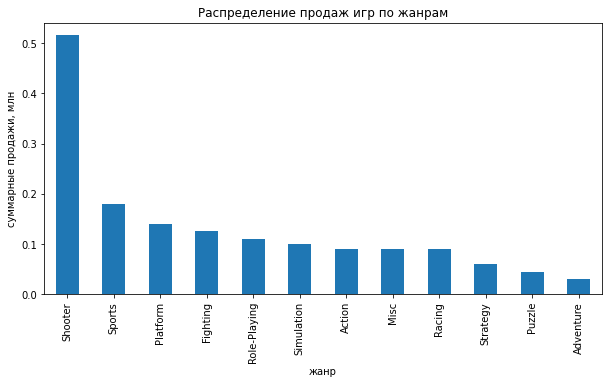

In [41]:
plt.figure(figsize=(10, 5))
games_df.groupby('genre')['total_sales'].median().sort_values(ascending=False).plot(kind='bar')
plt.title('Распределение продаж игр по жанрам')
plt.xlabel('жанр')
plt.ylabel('суммарные продажи, млн')

Самым популярным жанром является 'shooter'. В среднем игра такого жанра расходится тиражом в 0.5 млн копий. За ним идет 'sports', с продажами около 0.2 млн копий за игру. Дальше жанры расоплагаются в следующем порядке: 'Platform', 'Fighting', 'Role-Playing', 'Simulation', 'Action', 'Misc', 'Racing', с продажами в среднем 100000-130000 копий за игру. Замыкают список жанры: 'Strategy', 'Puzzle', 'Adventure'. На игры этих жанров продаж в среднем приходится по 50000 копий.

### Шаг 4. Составление портрета пользователя каждого региона

У нас имееются данные для пользователей из трех регионов: Северной Америки, Европы и Японии. Определим для пользователей каждого региона топ-5 популряных игровы платформ, топ-5 популярных жанров и посмотрим влияет ли рейтинг ESRB на продажи.

In [42]:
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,<NA>,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,<NA>,NaN,NaN,7.98


#### Топ-5 популярных платформ для разных регионов

In [43]:
na_users_platform = games_df.pivot_table(index='platform', values=['na_sales'], aggfunc='sum').sort_values(by='na_sales', ascending=False)
na_users_platform[:5]

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


In [44]:
eu_users_platform = games_df.pivot_table(index='platform', values=['eu_sales'], aggfunc='sum').sort_values(by='eu_sales', ascending=False)
eu_users_platform[:5]

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


In [45]:
jp_users_platform = games_df.pivot_table(index='platform', values=['jp_sales'], aggfunc='sum').sort_values(by='jp_sales', ascending=False)
jp_users_platform[:5]

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


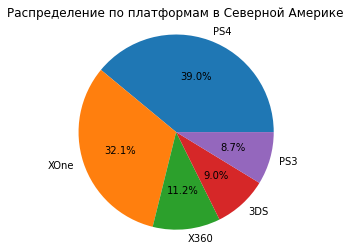

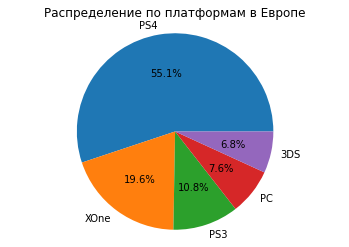

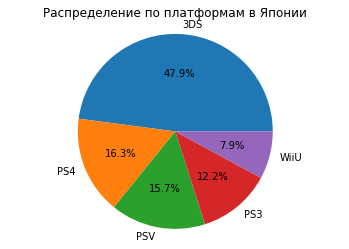

In [46]:
fig1, ax1 = plt.subplots()
ax1.pie(na_users_platform[:5].reset_index()['na_sales'], labels=na_users_platform[:5].reset_index()['platform'], autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Распределение по платформам в Северной Америке')

fig2, ax2 = plt.subplots()
ax2.pie(eu_users_platform[:5].reset_index()['eu_sales'], labels=eu_users_platform[:5].reset_index()['platform'], autopct='%1.1f%%')
ax2.axis('equal')
plt.title('Распределение по платформам в Европе')

fig3, ax3 = plt.subplots()
ax3.pie(jp_users_platform[:5].reset_index()['jp_sales'], labels=jp_users_platform[:5].reset_index()['platform'], autopct='%1.1f%%')
ax3.axis('equal')
plt.title('Распределение по платформам в Японии')
plt.show()



В разных регионах преобладают различные игровые платформы. 
В Северной Америке большую часть рынка занимают PS4 и XOne, занимая 39% и 32% соответственно. Так же представлены эти приставки, но прошлого поколения PS3 и X360, а также 3DS, каждая из которых занимает порядка 10% рынка. Это объясняется тем, что PS и XBox - принадлежат американским компаниям, соотвественно, они хорошо работают на свой рынок, как самый понятный.
В Европе преобладает PS4, занимая большую часть рынка (около 55%). Меньше представлена приставка XOne (~20%) и оставшийся рынок делится между PS3, 3DS и PC. Здесь всплыли PC, и стационарные приставки занимают большую часть рынка. Можно предположить, что европейцы привыкли играть в непереносные устройства, поэтому такое распределение по платформам. И к тому же маркетинг, PS лучше работает в европе, чем XBox'а.
В Японии наибольшее распространение получила приставка 3DS, которая занимает половину рынка. Это объясняется тем, что компания Nintendo, которая ее производит - японская, и она лучше знает свой родной рынок, чем американские компании. По мимо этого присутствуют WiiU и PSV. Выходит, что в Японии в целом отдают предпочтения портативным приставкам, суммарно они занимают около 70% рынка. Оставшаяся же часть отдается стационарным приставкам PS4 и PS3.

#### Топ-5 популярных жанров для разных регионов

In [47]:
na_users_genre = games_df.pivot_table(index='genre', values=['na_sales'], aggfunc='sum').sort_values(by='na_sales', ascending=False)
na_users_genre[:5]

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


In [48]:
eu_users_genre = games_df.pivot_table(index='genre', values=['eu_sales'], aggfunc='sum').sort_values(by='eu_sales', ascending=False)
eu_users_genre[:5]

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


In [49]:
jp_users_genre = games_df.pivot_table(index='genre', values=['jp_sales'], aggfunc='sum').sort_values(by='jp_sales', ascending=False)
jp_users_genre[:5]

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


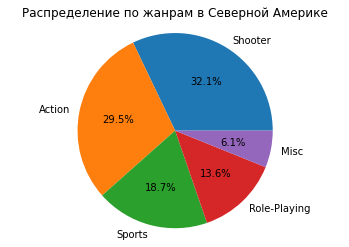

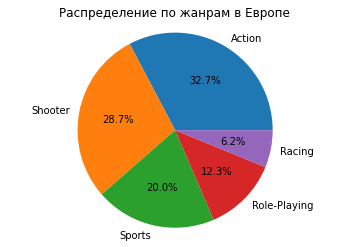

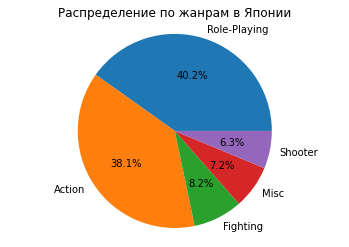

In [50]:
fig1, ax1 = plt.subplots()
ax1.pie(na_users_genre[:5].reset_index()['na_sales'], labels=na_users_genre[:5].reset_index()['genre'], autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Распределение по жанрам в Северной Америке')

fig2, ax2 = plt.subplots()
ax2.pie(eu_users_genre[:5].reset_index()['eu_sales'], labels=eu_users_genre[:5].reset_index()['genre'], autopct='%1.1f%%')
ax2.axis('equal')
plt.title('Распределение по жанрам в Европе')

fig3, ax3 = plt.subplots()
ax3.pie(jp_users_genre[:5].reset_index()['jp_sales'], labels=jp_users_genre[:5].reset_index()['genre'], autopct='%1.1f%%')
ax3.axis('equal')
plt.title('Распределение по жанрам в Японии')
plt.show()


В Америке и Европе схожее распределение игр по жанрам. Большую часть занимают игры в жанрах 'shooter' и 'action' (порядка 60%). Около 20% занимает жанр 'sport', около 13% жанр 'role-playing'.
В Японии же имеются различия. Так, жанр 'action' остается таким же популярным, но наряду с ним стоит жанр 'role-playing', занимая 40% рынка. А жанр 'shooter', который имеет широкое распространение в други регионах, в Японии занимаешь лишь 6%.

Проверим, влияет ли рейтинг ESRB на продажи в отдельном регионе

In [51]:
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,NaN,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,<NA>,NaN,NaN,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,<NA>,NaN,NaN,7.98


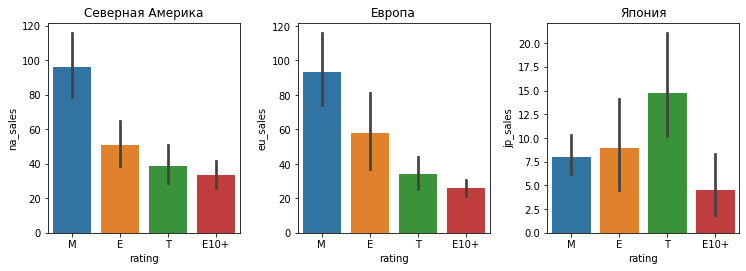

In [52]:
#удалим строки, где нет оценок пользователей и критиков
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=1.0, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)

plt.subplot(1, 3, 1)
plt.xlabel('рейтинг ESRB')
plt.ylabel('количество, млн')
plt.title('Северная Америка')
sns.barplot(data = games_df, x = 'rating', y= 'na_sales', estimator=sum)

plt.subplot(1, 3, 2)
plt.xlabel('рейтинг ESRB')
plt.ylabel('количество, млн')
plt.title('Европа')
sns.barplot(data = games_df, x = 'rating', y= 'eu_sales', estimator=sum)

plt.subplot(1, 3, 3)
plt.xlabel('рейтинг ESRB')
plt.ylabel('количество, млн')
plt.title('Япония')
sns.barplot(data = games_df, x = 'rating', y= 'jp_sales', estimator=sum)
plt.show()

Получилось, что рейтинг не влият на продажи. В Северной Америке и Европе больше всего продаются игр с рейтингом M, в то время, как в японии больше всего с рейтингом T (без рейтинга).

### Шаг 5. Проверка гипотез

Проверим, являются ли средние пользовательские рейтинги платформ Xbox One и PC одинаковыми.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные.

In [53]:
xbox_one = games_df[games_df['platform'] == 'XOne'].dropna(subset=['user_score']).reset_index(drop=True)
pc = games_df[games_df['platform'] == 'PC'].dropna(subset=['user_score']).reset_index(drop=True)
#выборка оценок пользователей на xbox
xbox_one_users_rating  = xbox_one['user_score']
#выборка оценок пользователей на pc
pc_users_rating  = pc['user_score']

# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(xbox_one_users_rating, pc_users_rating)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')

p-value: 0.10450507919348415


Значение p-value получилось порядка 10%, что выше уровня значимости, поэтому мы не можем отвергнуть нулевую гипотезу. Имеет смысл преподлагать, что средние пользовательские рейтинги платформ Xbox One и PC не различаются.

Проверим, явлюяются ли средние пользовательские рейтинги жанров 'Action' и 'Sports' разными.

Нулевая гипотеза: средние пользовательские рейтинги жанров 'Action' и 'Sports' одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги жанров 'Action' и 'Sports' разные.

In [54]:
genre_action = games_df[games_df['genre'] == 'Action'].dropna(subset=['user_score']).reset_index(drop=True)
genre_sports = games_df[games_df['genre'] == 'Sports'].dropna(subset=['user_score']).reset_index(drop=True)
#выборка оценок пользователей в жанре 'action'
action_users_rating  = genre_action['user_score']
#выборка оценок пользователей в жанре 'sports'
sports_users_rating  = genre_sports['user_score']

# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(action_users_rating, sports_users_rating)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')

p-value: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


Значение p-value получилось намного меньше уровня значимости, поэтому мы отвергаем нулевую гипотезу. Можно говорить о том что средние пользовательские рейтинги жанров 'Action' и 'Sports' различаются.

### Шаг 6. Вывод

По исходным данным мы узнали, как развивался рынок игр и что на нем сейчас происходит. До 1994 года выходило порядка 20-50 игр в год, а после этого пошло развитие этой индустрии с пиком в 2008-2009 годах (по 1400 игр в год). В дальнейшем стал происходить спад, и в 2016 году вышло порядка 500 игр. Это может быть связано с тем, что игры стали более сложными в разработке, и на выпуск игры требуется больше времени. 

За время развития игровой индустрии поменялось больше количество платформ. Средний срок жизни платформы составляет порядка 7.5 лет. Так например, самые популярные плтаформы в 2009 году - Wii, PS3, X360, DS, к 2014 году практически исчезли. А с 2013 начали активно расти PS4, XOne, 3DS. Для прогнозирования продаж на 2017 год имеет смысл рассматривать акутальный период - 2014-2016 года, где рынок перераспределился между новыми игровыми платформами.

Мы проверили, как рейтинг критиков и пользователей влияет на продажи игр. Присутсвует корреляция между рейтингом критиков и продажами игры (порядка 0.4). Это можно объяснить тем, что критики при оценке используют некоторые парамерты, которые является объективными, не опираясь только на свой субъективный опыт. Также своей оценкой критики могут формировать отношение к игре у потенциальных покупателей. Поэтому высокие оценки, побуждают покупателя приобрести игру, а низкие - нет. Что касается зависимости отзывов пользователей от продаж - то тут корреляция около нуля для стационарных приставок последнего поколения, но корреляция присутсвует, хоть и небольшая (около 0.2) среди приставок, который вышли раньше. Видимо там достаточно пользовательских отзывов, чтобы опираться на них при выборе игры.

Самым популярным жанром является 'shooter'. В среднем игра такого жанра расходится тиражом в 0.5 млн копий. За ним идет 'sports', с продажами около 0.2 млн копий за игру. Дальше жанры расоплагаются в следующем порядке: 'Platform', 'Fighting', 'Role-Playing', 'Simulation', 'Action', 'Misc', 'Racing', с продажами в среднем 100000-130000 копий за игру. Замыкают список жанры: 'Strategy', 'Puzzle', 'Adventure'. На игры этих жанров продаж в среднем приходится по 50000 копий.

В нашей таблице имеется информация о продаже игр в различных регионах: Северной Америке, Европе и Японии. В каждом регионе есть свои особенности. В разных регионах преобладают различные игровые платформы. 

В Северной Америке большую часть рынка занимают PS4 и XOne, занимая 39% и 32% соответственно. Так же представлены эти приставки, но прошлого поколения PS3 и X360, а также 3DS, каждая из которых занимает порядка 10% рынка. Это объясняется тем, что PS и XBox - принадлежат американским компаниям, соотвественно, они хорошо работают на свой рынок, как самый понятный.

В Европе преобладает PS4, занимая большую часть рынка (около 55%). Меньше представлена приставка XOne (~20%) и оставшийся рынок делится между PS3, 3DS и PC. Здесь всплыли PC, и стационарные приставки занимают большую часть рынка. Можно предположить, что европейцы привыкли играть в непереносные устройства, поэтому такое распределение по платформам. И к тому же маркетинг, PS лучше работает в европе, чем XBox'а.

В Японии наибольшее распространение получила приставка 3DS, которая занимает половину рынка. Это объясняется тем, что компания Nintendo, которая ее производит - японская, и она лучше знает свой родной рынок, чем американские компании. По мимо этого присутствуют WiiU и PSV. Выходит, что в Японии в целом отдают предпочтения портативным приставкам, суммарно они занимают около 70% рынка. Оставшаяся же часть отдается стационарным приставкам PS4 и PS3.

Помимо различий в платформах, в разных регионах отдаются предпочтения различным игровым жанрам. В Америке и Европе схожее распределение игр по жанрам. Большую часть занимают игры в жанрах 'shooter' и 'action' (порядка 60%). Около 20% занимает жанр 'sport', около 13% жанр 'role-playing'.
В Японии же имеются различия. Так, жанр 'action' остается таким же популярным, но наряду с ним стоит жанр 'role-playing', занимая 40% рынка. А жанр 'shooter', который имеет широкое распространение в други регионах, в Японии занимаешь лишь 6%.

Для того, чтобы выяснить, какие игры стоит закупать в следующем году, мы проверили пару гипотез: являются ли средние пользовательские рейтинги платформ Xbox One и PC одинаковыми и явлюяются ли средние пользовательские рейтинги жанров 'Action' и 'Sports' разными. Имеет смысл преподлагать, что средние пользовательские рейтинги платформ Xbox One и PC не различаются, поэтому при закупке игр, не стоит отдавать предпочтение только одной из двух платформ. А вот что касается жанра, можно говорить о том, что средние пользовательские рейтинги жанров 'Action' и 'Sports' различаются, но как мы выяснили ранее, это не повлияет на продажи игры.